<a href="https://colab.research.google.com/github/MSVGH1/IAD/blob/main/%D0%9B%D0%A05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# відключимо попередження Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [ ]:
# задамо графіки у форматі .svg, щоби вони мали кращу чіткість
%config InlineBackend.figure_format = 'svg' 

# підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

In [ ]:
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

In [ ]:
credit_scoring_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-05_logit-rf-credit-scoring/credit_scoring_sample.csv'

data = pd.read_csv(credit_scoring_url, sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [ ]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

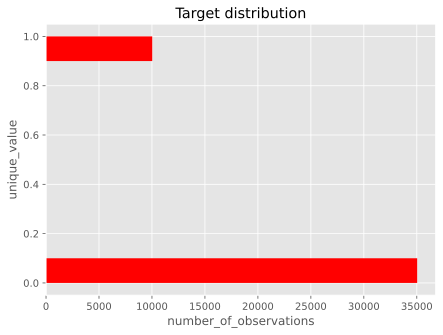

In [ ]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [ ]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [ ]:
table = delete_nan(data)

In [ ]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [ ]:
# Функція для генерації підвибірок за допомогою бутстрепу
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [19]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [30]:
#Завдання 1

# Зберігаємо дані щодо клієнтів в окремі numpy масиви 
churn_clients = data[data['SeriousDlqin2yrs'] == 1]['age'].values


# Cтавимо seed для відтворюваності результатів
np.random.seed(0)

# Формуємо вибірки за допомогою бутстрепу і відразу обраховуємо за кожною з них середнє
churn_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(churn_clients, 1000)]


# Виводимо інтервальну оцінку середнього
print("Інтервальна оцінка середнього віку не надійних клієнтів: ", stat_intervals(churn_mean_scores, 0.05))


Інтервальна оцінка середнього віку не надійних клієнтів:  [45.68145322 46.16947187]


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [32]:
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

In [33]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In [34]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [35]:
%%time
lr_grid_search = GridSearchCV(lr, parameters, n_jobs=-1, scoring ='roc_auc', cv=skf)
lr_grid_search = lr_grid_search.fit(X, y)

CPU times: user 934 ms, sys: 621 ms, total: 1.56 s
Wall time: 11.1 s


In [40]:
#Заідання 2

log_accuracy = lr_grid_search.best_score_

best_intex = lr_grid_search.best_index_
if (0.5>(lr_grid_search.cv_results_['std_test_score'][best_intex])):
    print ("Так модель стійка")
else:
    print ("Ні, модель не стійка")
    
lr_grid_search.cv_results_['std_test_score'][best_intex]

Так модель стійка


0.008137559189742445

In [42]:
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C=0.001,random_state=5, class_weight='balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [70]:
pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.446832
3,NumberOfTimes90DaysLate,0.390381
4,NumberOfTime60-89DaysPastDueNotWorse,0.216038
6,NumberOfDependents,0.191726
2,DebtRatio,-0.000006
5,MonthlyIncome,-0.000011
0,age,-0.013656


In [47]:
#Завдання 3
#lr = LogisticRegression(C=0.001,random_state=5, class_weight= 'balanced')
#lr.fit(X, y)

#pd.DataFrame({'feat': independent_columns_names,
#              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

In [71]:
np.exp(lr.coef_[0][0]*10)

0.8723581255234459

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')

In [73]:
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7], 
              'max_depth': [5, 10, 15]}

In [74]:
%%time
rf_grid_search = GridSearchCV(rf, parameters, n_jobs=-1, scoring ='roc_auc', cv=skf)
rf_grid_search = rf_grid_search.fit(X, y)

CPU times: user 2.01 s, sys: 363 ms, total: 2.37 s
Wall time: 50.7 s


In [76]:
#Завдання 4
independent_columns_names[np.argmin(rf_grid_search.best_estimator_.feature_importances_)]

'NumberOfDependents'

In [78]:
%%time
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=5, oob_score=True, class_weight='balanced',**rf_grid_search.best_params_)
rf.fit(X,y)

CPU times: user 5.95 s, sys: 304 ms, total: 6.25 s
Wall time: 3.64 s


RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,
                       min_samples_leaf=5, n_jobs=-1, oob_score=True,
                       random_state=5)

In [79]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [80]:
parameters = {'max_features': [1, 2, 3], 'max_samples': [0.1, 0.3, 0.5], 
              "base_estimator__C": [0.0001, 0.001, 0.01]}

In [84]:
bg=BaggingClassifier(LogisticRegression(class_weight= 'balanced'),random_state=42,n_estimators=100, n_jobs=-1)

In [86]:
%%time
bg_random_search = RandomizedSearchCV(bg, parameters,cv=skf, n_jobs=-1, random_state=1,n_iter=20,scoring='roc_auc')

bg_random_search = bg_random_search.fit(X, y)

CPU times: user 6.56 s, sys: 950 ms, total: 7.51 s
Wall time: 15min 14s


In [90]:
#Завдання 5
bg_random_search.best_score_

0.8071386555733977

In [ ]:
#1.для бэггинга важно использовать как можно меньше признаков
#2.бэггинг лучше работает на небольших выборках
#3.меньше корреляция между одиночными моделями
#4.чем больше признаков, тем меньше теряется информации